In [22]:
import sys
import os

project_root = '/Users/irwin/Documents/GitHub/lisa-ml'
sys.path.append(project_root)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import ldc.io.hdf5 as h5io
from ldc.lisa.noise import get_noise_model 
import torch
from src.model import BinaryClassifier 
import src.data as data
from src.eval import evaluate_model

In [25]:
model = BinaryClassifier(input_dim=5)  
model.load_state_dict(torch.load('/Users/irwin/Documents/GitHub/lisa-ml/models/best_multi_task_classifier_Binary_Baseline_weighted_log_class1_100.pth', map_location='cpu'))

<All keys matched successfully>

In [17]:
config_path = "/Users/irwin/Documents/GitHub/lisa-ml/src/config/config.yaml"
config = data.load_config(config_path)
(
    train_loader,
    val_loader,
    input_dim,
    num_model_classes,
    scaler,
    binary_encoder,
    model_encoder,
) = data.load_data(config)

Processed file: resolved_Model2_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5
Processed file: resolved_Model2_2_MW_DWDs_aa2CE_NSWDs_aa2CE_akick.h5
Processed file: resolved_Model3_1_MW_DWDs_agCE_NSWDs_agCE_vkick.h5
Processed file: resolved_Model3_0_MW_DWDs_agCE.h5
Processed file: resolved_Model1_1_MW_DWDs_aaCE_NSWDs_aaCE_vkick.h5
Processed file: resolved_Model1_0_MW_DWDs_aaCE.h5
Processed file: resolved_Model1_2_MW_DWDs_aaCE_NSWDs_aaCE_akick.h5
Processed file: resolved_Model2_4_MW_DWDs_aa2CE_NSWDs_aa2CE_bkick.h5
Processed file: resolved_Model1_4_MW_DWDs_aaCE_NSWDs_aaCE_bkick.h5
Processed file: resolved_Model2_3_MW_DWDs_aa2CE_NSWDs_aa2CE_hkick.h5
Processed file: resolved_Model1_3_MW_DWDs_aaCE_NSWDs_aaCE_hkick.h5


/Users/irwin/Documents/GitHub/lisa-ml/src/data.py:93: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, size=n_samples)


In [26]:
binary_preds, binary_true, = evaluate_model(
    model, val_loader
)

In [43]:
all_inputs = []
all_labels = []

for batch in val_loader:
    inputs =  batch[0]
    labels = batch[1] # adjust if your dataset returns something else
    all_inputs.append(inputs)
    all_labels.append(labels)

# Stack tensors and convert to numpy
X = torch.cat(all_inputs).numpy()
y = torch.cat(all_labels).numpy()
X_original = scaler.inverse_transform(X)
# Optionally: create column names
input_dim = X.shape[1]
columns = ["Frequency_mHz", "Amplitude_log10", "FrequencyDerivative_log10", "SNR", "Eccentricity"]

# Construct DataFrame
df = pd.DataFrame(X_original, columns=columns)
df['label'] = y

In [46]:
from ldc.common.constants import SPEED_OF_LIGHT, GM_SUN, PARSEC, ASTRONOMICAL_YEAR
Tobs     = 4*ASTRONOMICAL_YEAR                # Duration of the measurement
f_range        = np.linspace(1e-4,1e-1,1000)        # The frequency array
lisa_noise = get_noise_model('SciRDv1', f_range)

In [48]:


# Estimate luminosity distance (in kpc) from GW amplitude, frequency, and frequency derivative
def get_DL(Amp0, f0, fdot):
    return (5/(96*(np.pi**2)))*(SPEED_OF_LIGHT/Amp0)*(fdot)/np.power(f0,3)*(1/(1000*PARSEC))

# Estimate chirp Mass
def get_Mc(f0, fdot):
    return SPEED_OF_LIGHT**3/GM_SUN * ( (5/96) * np.pi**(-8/3) * f0**(-11/3) * fdot)**(3/5)
freq_mHz = df['Frequency_mHz']                 # in mHz
f       = freq_mHz / 1000                         # convert to Hz
amp_log  = df['Amplitude_log10']               # log10(h0)
h0      = 10**amp_log                             # strain amplitude
fdot_log = df['FrequencyDerivative_log10']     # log10(df/dt)
fdot    = 10**fdot_log  
dL    = get_DL(h0, f, fdot) # Transform to the distances and chirp masses
Mchrp = get_Mc(f, fdot)
hc = np.sqrt(16/5) * np.sqrt(Tobs*f) * h0
df['h_c'] = hc

In [49]:
lisasens = lisa_noise.sensitivity()

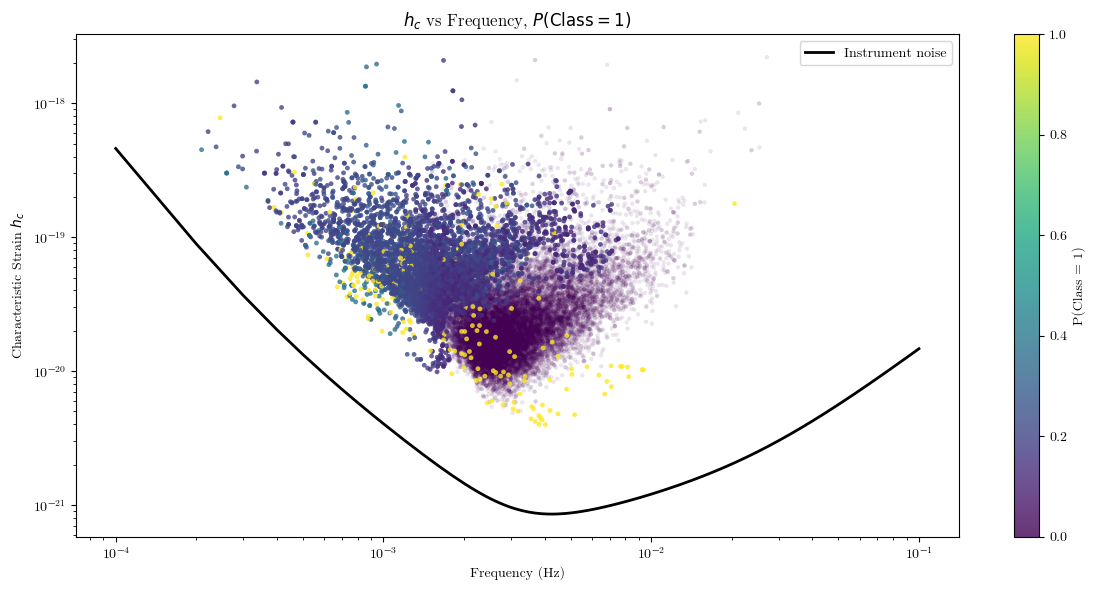

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

p1    = binary_preds


threshold = 0.1
low_mask  = p1 <= threshold
high_mask = ~low_mask


plt.rc('font', family='Latin Modern Roman', size=10)
norm = Normalize(vmin=0, vmax=1)
cmap = cm.viridis


plt.figure(figsize=(12, 6))
plt.loglog(f_range, np.sqrt( f_range * lisasens/2), 'k-', linewidth=2, label='Instrument noise')
#   a) low‑prob
plt.scatter(
    f[low_mask], hc[low_mask],
    c=p1[low_mask], cmap=cmap, norm=norm,
    alpha=0.1, edgecolor='none', zorder=1, s=10
)

#   b) high‑prob
sc = plt.scatter(
    f[high_mask], hc[high_mask],
    c=p1[high_mask], cmap=cmap, norm=norm,
    alpha=0.8, edgecolor='none', zorder=2, s=12
)


plt.xscale('log')
plt.yscale('log')   


plt.xlabel('Frequency (Hz)')
plt.ylabel('Characteristic Strain $h_c$')
plt.title(r'$h_c$ vs Frequency, $P(\mathrm{Class}=1)$')
cbar = plt.colorbar(sc)
cbar.set_label('P(Class = 1)')
plt.legend()
plt.tight_layout()


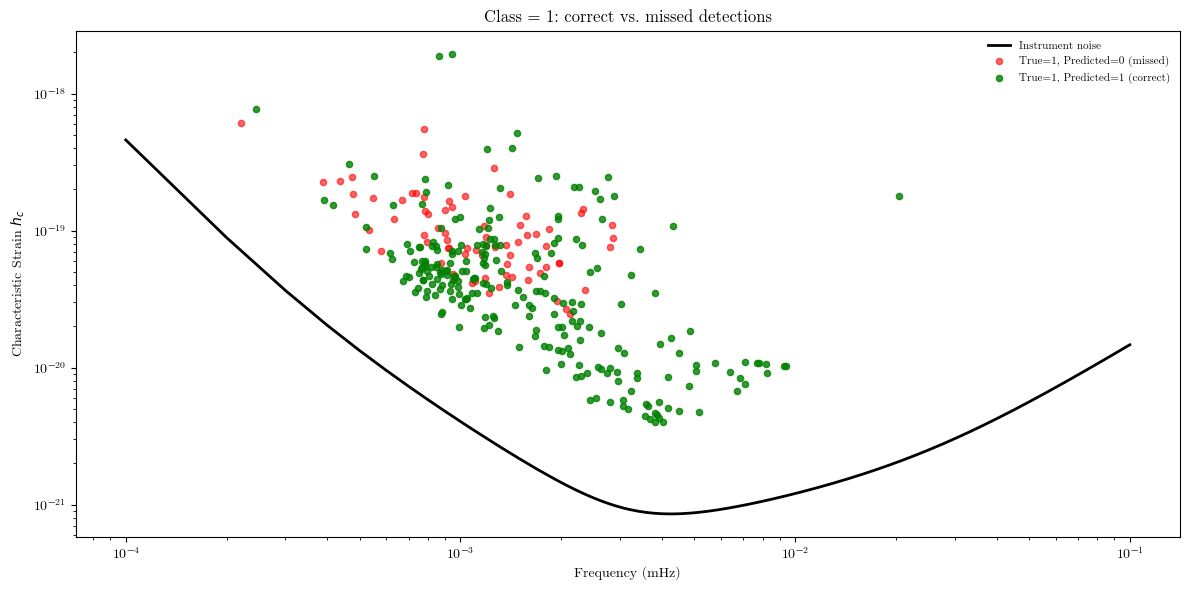

In [57]:
score = 0.3
y_pred   = (binary_preds >= score).astype(int)
y_true   = binary_true
mask_pos = (y_true == 1)
mask_tp  = mask_pos & (y_pred == 1)   # true positives
mask_fn  = mask_pos & (y_pred == 0)   # false negatives

plt.figure(figsize=(12, 6))
plt.loglog(f_range, np.sqrt( f_range * lisasens/2), 'k-', linewidth=2, label='Instrument noise')

# a) Missed (false negatives) in red
plt.scatter(
    f[mask_fn], hc[mask_fn],
    s=20, c='red', alpha=0.6,
    label='True=1, Predicted=0 (missed)',
    zorder=1
)

# b) Correct (true positives) in green
sc = plt.scatter(
    f[mask_tp], hc[mask_tp],
    s=20, c='green', alpha=0.8,
    label='True=1, Predicted=1 (correct)',
    zorder=2
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (mHz)')
plt.ylabel(r'Characteristic Strain $h_c$')
plt.title('Class = 1: correct vs. missed detections')
plt.legend(loc='upper right', fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

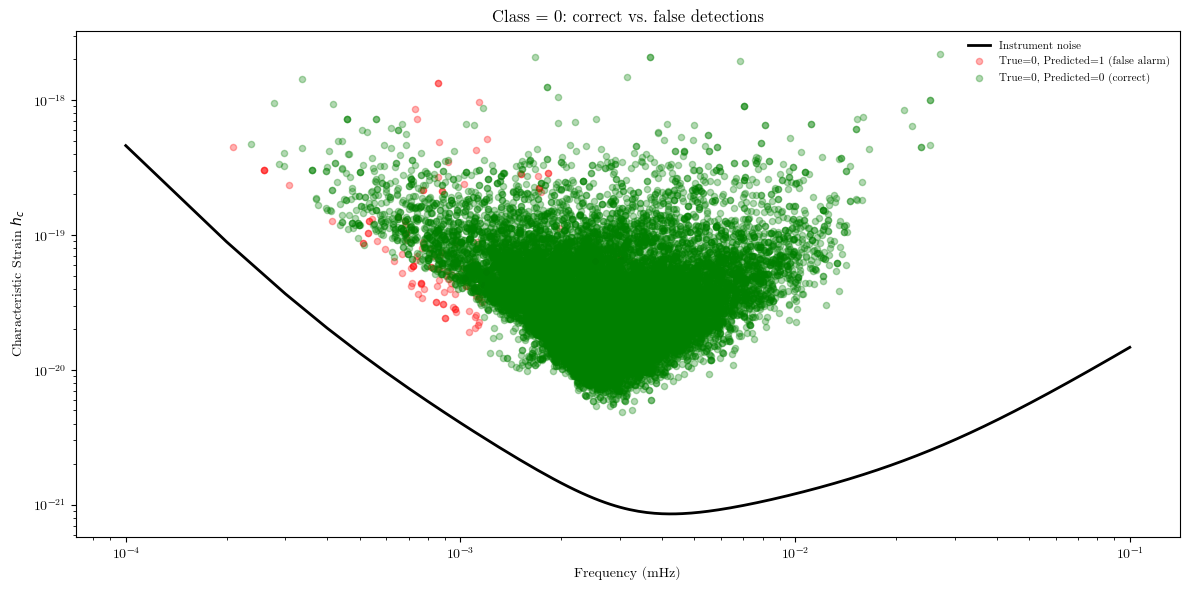

In [58]:
score = 0.3
y_pred   = (binary_preds >= score).astype(int)
y_true   = binary_true

# Focus on class 0
mask_neg = (y_true == 0)
mask_tn  = mask_neg & (y_pred == 0)   # true negatives
mask_fp  = mask_neg & (y_pred == 1)   # false positives

plt.figure(figsize=(12, 6))
plt.loglog(f_range, np.sqrt(f_range * lisasens / 2), 'k-', linewidth=2, label='Instrument noise')

# a) Incorrect (false positives) in red
plt.scatter(
    f[mask_fp], hc[mask_fp],
    s=20, c='red', alpha=0.3,
    label='True=0, Predicted=1 (false alarm)',
    zorder=1
)

# b) Correct (true negatives) in green
plt.scatter(
    f[mask_tn], hc[mask_tn],
    s=20, c='green', alpha=0.3,
    label='True=0, Predicted=0 (correct)',
    zorder=2
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (mHz)')
plt.ylabel(r'Characteristic Strain $h_c$')
plt.title('Class = 0: correct vs. false detections')
plt.legend(loc='upper right', fontsize=8, frameon=False)
plt.tight_layout()
plt.show()